# Structural Anatomy of the Dark Web: An Analysis of Hidden Service Connectivity

## Complex Networks Final Report

### Victor Alexander Capa Sandoval

#### Libraries

In [38]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
from networkx.algorithms import community
import csv
import os

try:
    import powerlaw
except ImportError:
    print("Installing powerlaw...")
    !pip install powerlaw

#### Plot parameters

In [14]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['DejaVu Serif'],
    'mathtext.fontset': 'cm',
    'font.size': 12,
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 16,
    'figure.titlesize': 18,
    'lines.linewidth': 2,
    'lines.markersize': 10,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--'
})

#### Network Import

`darkweb-edges.ss` file must be in this directory.

In [36]:
df_edges = pd.read_csv('data/darkweb-edges.ss', sep=';')
G_dir = nx.from_pandas_edgelist(df_edges, source='Source', target='Target',create_using=nx.DiGraph())
G = G_dir.to_undirected()

#### Basic properties

In [8]:
V = G.number_of_nodes()
E = G.number_of_edges()

D = nx.density(G)
T = nx.transitivity(G)
C = nx.average_clustering(G)

P = [k for n, k in G.degree()]
avg_k = np.mean(P)

In [24]:
a = nx.average_shortest_path_length(G)

In [25]:
d = nx.diameter(G)

In [26]:
r = nx.degree_assortativity_coefficient(G)

In [27]:
print(f"Number of nodes: {V}")
print(f"Number of edges: {E}")
print(f"Density: {D:.6f}")
print(f"Average degree: {avg_k:.4f}")
print(f"Transitivity: {T:.5f}")
print(f"Clustering coefficient: {C:.4f}")
print(f"Average shortest path length: {a:.4f}")
print(f"Diameter: {d}")
print(f"Degree assortativity: {r:.4f}")

Number of nodes: 7178
Number of edges: 24879
Density: 0.000966
Average degree: 6.9320
Transitivity: 0.00445
Clustering coefficient: 0.7061
Average shortest path length: 2.3704
Diameter: 5
Degree assortativity: -0.4429


#### Degree distribution

In [12]:
fit = powerlaw.Fit(P, discrete=True)

print(f"Exponent: {fit.power_law.alpha}")
print(f"$Cutoff$: {fit.power_law.xmin}")

R, pp = fit.distribution_compare('power_law', 'exponential')
print(f"Power law vs Exponential: R={R}, p={pp}")
if R > 0 and pp < 0.05:
    print("Power law is better fit compared to exponential.")

R, pp = fit.distribution_compare('power_law', 'lognormal')
print(f"Power law vs Log Normal: R={R}, p={pp}")
if R > 0 and pp < 0.05:
    print("Power law is better fit compared to lognormal.")


Calculating best minimal value for power law fit


Fitting xmin: 100%|██████████| 99/99 [00:00<00:00, 1080.96it/s]

Exponent: 2.0535263800498265
$Cutoff$: 23.0
Power law vs Exponential: R=157.54516029077521, p=7.053165271934355e-05
Power law is better fit compared to exponential.
Power law vs Log Normal: R=0.0035059452076233732, p=0.6904866607487425



/usr/local/lib/python3.12/dist-packages/powerlaw/distributions.py:808: UserWarning: Fitted parameters are very close to the edge of parameter ranges for distribution exponential; consider changing these ranges.
  warnings.warn(f'Fitted parameters are very close to the edge of parameter ranges for distribution {self.name}; consider changing these ranges.')
/usr/local/lib/python3.12/dist-packages/powerlaw/distributions.py:2792: RuntimeWarning: invalid value encountered in divide
  return likelihoods/norm
/usr/local/lib/python3.12/dist-packages/powerlaw/distributions.py:776: UserWarning: No valid fits found for distribution lognormal.
  warnings.warn(f"No valid fits found for distribution {self.name}.")


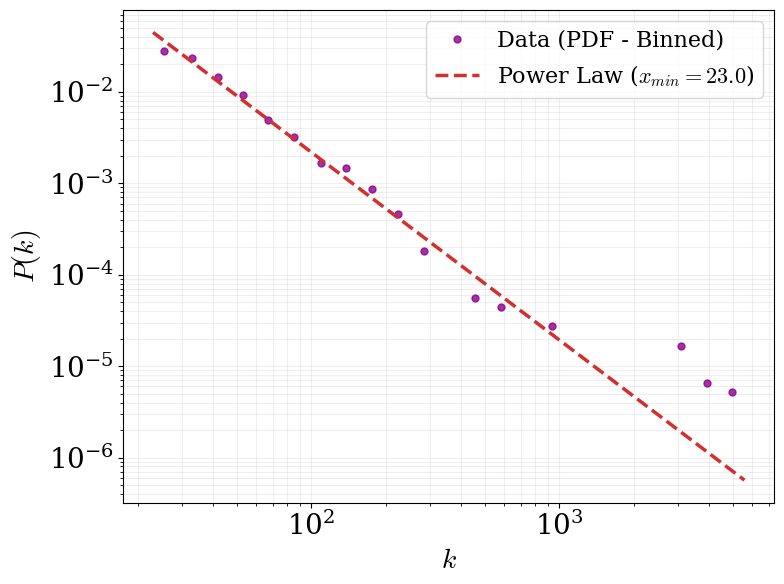

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
fit.plot_pdf(ax=ax, color='darkmagenta', marker='.', linestyle='None',linewidth=0, alpha=0.8, label='Data (PDF - Binned)')
fit.power_law.plot_pdf(ax=ax, color='#D32F2F', linestyle='--',linewidth=2.5, label=r'Power Law ($x_{min}=23.0$)')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')
ax.grid(True, which="both", ls="-", alpha=0.2)
ax.legend()
plt.tight_layout()
plt.savefig("plots/pdf_darkweb.pdf", bbox_inches='tight')
plt.show()

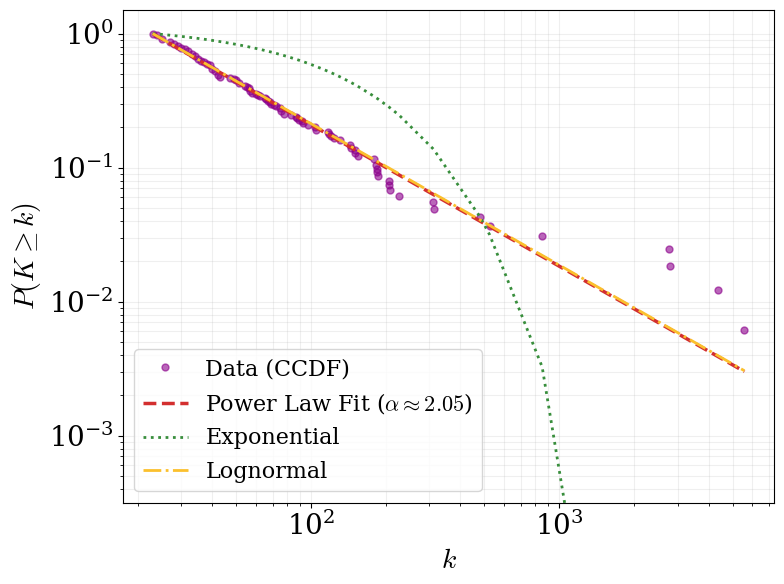

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

fit.plot_ccdf(ax=ax, color='darkmagenta', linewidth=0, marker='o',markersize=5, alpha=0.6, label='Data (CCDF)')

fit.power_law.plot_ccdf(ax=ax, color='#D32F2F', linestyle='--',linewidth=2.5, label=r'Power Law Fit ($\alpha \approx 2.05$)')

fit.exponential.plot_ccdf(ax=ax, color='#388E3C', linestyle=':',linewidth=2, label='Exponential')

fit.lognormal.plot_ccdf(ax=ax, color='#FBC02D', linestyle='-.',linewidth=2, label='Lognormal')

ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P(K \geq k)$')

ax.legend(loc='lower left')

ax.set_ylim(10**-3.5,1.5)
ax.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()

plt.savefig("plots/ccdf_darkweb.pdf", bbox_inches='tight')

plt.show()

#### Centrality analysis

In [ ]:
deg_cent = nx.degree_centrality(G)

try:
    eig_cent = nx.eigenvector_centrality(G, max_iter=1000)
except:
    eig_cent = nx.eigenvector_centrality_numpy(G)

bet_cent = nx.betweenness_centrality(G)

In [ ]:
close_cent = nx.closeness_centrality(G)

pagerank_cent = nx.pagerank(G, alpha=0.85)

In [ ]:
try:
    L = nx.adjacency_spectrum(G)
    lambda_max = np.max(np.real(L))
    alph = 1 / lambda_max * 0.9 #(0.9: Below the theoretical limit)

    katz_cent = nx.katz_centrality_numpy(G, alpha=alph)

except Exception as e:
    print(f"Error: {e}")
    katz_cent = nx.katz_centrality(G, alpha=0.001)

In [37]:
subgraph_cent = nx.subgraph_centrality(G)

In [ ]:
def print_top(centrality_dict, name):
    top = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:25]
    print(f"\nTop 25 {name}:")
    for node, val in top:
        print(f"  Nodo {node}: {val:.4f}")

Top 25 of central nodes:

In [ ]:
print_top(deg_cent, "Degree")
print_top(eig_cent, "Eigenvector")
print_top(bet_cent, "Betweenness")
print_top(close_cent, "Closeness Centrality")
print_top(pagerank_cent, "PageRank")
print_top(katz_cent, "Katz Centrality")
print_top(subgraph_cent, "Subgraph Centrality")


Top 25 Degree:
  Nodo directoryvi6plzm: 0.7778
  Nodo visitorfi5kl7q7i: 0.6092
  Nodo skunksworkedp2cg: 0.3882
  Nodo cratedvnn5z57xhl: 0.3847
  Nodo gxamjbnu7uknahng: 0.1190
  Nodo torvps7kzis5ujfz: 0.0730
  Nodo zlal32teyptf4tvi: 0.0670
  Nodo hwikis25cffertqe: 0.0436
  Nodo w363zoq3ylux5rf5: 0.0431
  Nodo wikitorcwogtsifs: 0.0316
  Nodo fhostingesps6bly: 0.0291
  Nodo y4yhci7273s2yeqk: 0.0288
  Nodo auutwvpt2zktxwng: 0.0287
  Nodo hdwikicorldcisiy: 0.0261
  Nodo mijpsrtgf54l7um6: 0.0258
  Nodo wikiwarixvouhwyn: 0.0256
  Nodo zqktlwi4fecvo6ri: 0.0255
  Nodo 32b5oz2bbtn6gqj3: 0.0249
  Nodo nqigfqrxnkwcqmiq: 0.0249
  Nodo ntcixulmms4275vi: 0.0215
  Nodo kpvz7ki2lzvnwve7: 0.0210
  Nodo soupkso3la22ltl3: 0.0209
  Nodo wikihiddkz5w3hfg: 0.0202
  Nodo torwikignoueupfm: 0.0201
  Nodo n6pbizsbykwxmydz: 0.0183

Top 25 Eigenvector:
  Nodo directoryvi6plzm: 0.4463
  Nodo visitorfi5kl7q7i: 0.3883
  Nodo skunksworkedp2cg: 0.2562
  Nodo cratedvnn5z57xhl: 0.2493
  Nodo gxamjbnu7uknahng: 0.0662
  N

#### Communities

In [30]:
communities = community.greedy_modularity_communities(G)
Q = community.modularity(G, communities)

print(f"Number of communities: {len(communities)}")
print(f"Modularity: {Q:.4f}")

Number of communities: 12
Modularity: 0.3100


#### Heterogeneity - Gini Coefficient

We calculate the Gini coefficient to quantify the inequality of the centrality distributions, comparing the empirical network against the null models (Kunegis, J., & Preusse, J., 2012)

$$G = \frac{\sum_{i=1}^{N} \sum_{j=1}^{N} |x_i - x_j|}{2N^2 \bar{x}}$$

In [32]:
def heterogeneity(array):
    array = np.array(array, dtype=np.float64)
    if np.amin(array) < 0:
        array -= np.amin(array)
    array += 0.00000001
    array = np.sort(array)
    index = np.arange(1, array.shape[0] + 1)
    n = array.shape[0]

    return ((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)))

In [33]:
real_deg = list(nx.degree_centrality(G).values())
real_pr = list(nx.pagerank(G, alpha=0.85).values())
try:
    real_eig = list(nx.eigenvector_centrality_numpy(G).values())
except:
    real_eig = list(nx.eigenvector_centrality(G, max_iter=1000).values())

real_hg_deg = heterogeneity(real_deg)
real_hg_pr = heterogeneity(real_pr)
real_hg_eig = heterogeneity(real_eig)

#### Null-models and z-scores. Comparison analysis.

In [ ]:
def features(Graph_null):
    C_null = nx.average_clustering(Graph_null)
    T_null = nx.transitivity(Graph_null)
    A_null = nx.degree_assortativity_coefficient(Graph_null)

    if nx.is_connected(Graph_null):
        a_null = nx.average_shortest_path_length(Graph_null)
        d_null = nx.diameter(Graph_null)
    else:
        lcc_null = Graph_null.subgraph(max(nx.connected_components(Graph_null), key=len))
        a_null = nx.average_shortest_path_length(lcc_null)
        d_null = nx.diameter(lcc_null)

    try:
        comms_null = community.greedy_modularity_communities(Graph_null)
        Q_null = community.modularity(Graph_null, comms_null)
    except:
        Q_null = 0

    return [C_null, T_null, a_null, d_null, A_null, Q_null]

In [ ]:
n_simulations = 10
results = []
seeds = [6243,9435,9782,1864,8457,2572,3886,9458,8345,9285,1938,3547,8457,1123,8875,6931,9923,6378,3976,6865]

header = ['Model', 'Seed', 'Clustering', 'Transitivity', 'Avg Path', 'Diameter', 'Assortativity', 'Modularity']

m_ba = int(round(E / V)) # BA New edges per node -> Approximate Edges (m = E/N)

with open('results/null_models_results.csv', mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)

    for i in range(n_simulations):
        # ER
        G_er = nx.gnm_random_graph(V, E, seed=seeds[i])
        metrics_er = features(G_er)
        row_er = ['ER', seeds[i]] + metrics_er
        writer.writerow(row_er)
        results.append({'Model': 'ER', 'Data': metrics_er})

        # BA
        G_ba = nx.barabasi_albert_graph(V, m_ba, seed=seeds[-i-1])
        metrics_ba = features(G_ba)
        row_ba = ['BA', seeds[-i-1]] + metrics_ba
        writer.writerow(row_ba)
        results.append({'Model': 'BA', 'Data': metrics_ba})

        f.flush()

  Simulation 1/10...
  Simulation 2/10...
  Simulation 3/10...
  Simulation 4/10...
  Simulation 5/10...
  Simulation 6/10...
  Simulation 7/10...
  Simulation 8/10...
  Simulation 9/10...
  Simulation 10/10...


In [ ]:
def central_feature(Graph_null):
    deg_cent = list(nx.degree_centrality(Graph_null).values())
    pr_cent = list(nx.pagerank(Graph_null, alpha=0.85).values())

    try:
        eig_cent = list(nx.eigenvector_centrality_numpy(Graph_null).values())
    except:
        eig_cent = list(nx.eigenvector_centrality(Graph_null, max_iter=1000).values())

    gini_deg = heterogeneity(deg_cent)
    gini_pr = heterogeneity(pr_cent)
    gini_eig = heterogeneity(eig_cent)

    return [gini_deg, gini_pr, gini_eig]

In [ ]:
n_simulations = 10
results = []
seeds = [6243,9435,9782,1864,8457,2572,3886,9458,8345,9285,1938,3547,8457,1123,8875,6931,9923,6378,3976,6865]

header = ['Model', 'Seed', 'HG Degree', 'HG PageRank', 'HG Eigenvector']

m_ba = int(round(E / V))

with open('results/null_central_results.csv', mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)

    for i in range(n_simulations):
        # ER
        G_er = nx.gnm_random_graph(V, E, seed=seeds[i])
        metrics_er = central_feature(G_er)
        row_er = ['ER', seeds[i]] + metrics_er
        writer.writerow(row_er)
        results.append({'Model': 'ER', 'Data': metrics_er})

        # BA
        G_ba = nx.barabasi_albert_graph(V, m_ba, seed=seeds[-i-1])
        metrics_ba = central_feature(G_ba)
        row_ba = ['BA', seeds[-i-1]] + metrics_ba
        writer.writerow(row_ba)
        results.append({'Model': 'BA', 'Data': metrics_ba})

        f.flush()

In [34]:
try:
    df_topo = pd.read_csv('results/null_models_results.csv')
    df_cent = pd.read_csv('results/null_central_results.csv')
except FileNotFoundError:
    print("ERROR: Files .csv not found.")

cols_topo = ['Clustering', 'Transitivity', 'Avg Path', 'Diameter', 'Assortativity', 'Modularity']
cols_cent = ['HG Degree', 'HG PageRank', 'HG Eigenvector']

er_topo_mean = df_topo[df_topo['Model'] == 'ER'][cols_topo].mean()
er_cent_mean = df_cent[df_cent['Model'] == 'ER'][cols_cent].mean()
er_mean_all = pd.concat([er_topo_mean, er_cent_mean])

er_topo_std = df_topo[df_topo['Model'] == 'ER'][cols_topo].std()
er_cent_std = df_cent[df_cent['Model'] == 'ER'][cols_cent].std()
er_std_all = pd.concat([er_topo_std, er_cent_std])

ba_topo_mean = df_topo[df_topo['Model'] == 'BA'][cols_topo].mean()
ba_cent_mean = df_cent[df_cent['Model'] == 'BA'][cols_cent].mean()
ba_mean_all = pd.concat([ba_topo_mean, ba_cent_mean])

ba_topo_std = df_topo[df_topo['Model'] == 'BA'][cols_topo].std()
ba_cent_std = df_cent[df_cent['Model'] == 'BA'][cols_cent].std()
ba_std_all = pd.concat([ba_topo_std, ba_cent_std])

full_real_values = [C, T, a, d, r, Q, real_hg_deg, real_hg_pr, real_hg_eig]

all_columns = cols_topo + cols_cent

df_comparison = pd.DataFrame(index=all_columns)

df_comparison['Real Network'] = full_real_values

df_comparison['ER Mean'] = er_mean_all
df_comparison['ER Std'] = er_std_all

df_comparison['ER Z-Score'] = (df_comparison['Real Network'] - df_comparison['ER Mean']) / (df_comparison['ER Std'] + 1e-9)


df_comparison['BA Mean'] = ba_mean_all
df_comparison['BA Std'] = ba_std_all

df_comparison['BA Z-Score'] = (df_comparison['Real Network'] - df_comparison['BA Mean']) / (df_comparison['BA Std'] + 1e-9)

pd.set_option('display.float_format', '{:.4f}'.format)
print("\n" + "="*60)
print("NULL MODEL COMPARISON")
print("="*60)
display(df_comparison)


NULL MODEL COMPARISON


,Real Network,ER Mean,ER Std,ER Z-Score,BA Mean,BA Std,BA Z-Score
Clustering,0.7061,0.0009,0.0001,5614.1318,0.0066,0.0006,1198.0783
Transitivity,0.0044,0.0009,0.0001,35.9752,0.0035,0.0002,4.4923
Avg Path,2.3704,4.8053,0.0023,-1050.9201,4.1774,0.0178,-101.7123
Diameter,5.0000,8.9000,0.3162,-12.3329,7.0000,0.0000,-2000000000.0000
Assortativity,-0.4429,-0.0011,0.0046,-95.4801,-0.0429,0.0064,-62.4307
Modularity,0.3100,0.3419,0.0014,-23.5598,0.3933,0.0018,-47.4104
HG Degree,0.6954,0.2120,0.0013,386.5529,0.3758,0.0014,221.0862
HG PageRank,0.5940,0.1769,0.0010,416.8209,0.3290,0.0015,176.3004
HG Eigenvector,0.3440,0.2604,0.0024,34.4276,0.5977,0.0135,-18.8398


In [35]:
df_comparison.to_csv('results/null_models_comparison.csv', index=True)

#### Graph export for visualization

In [ ]:
G_viz = G.copy()

# PageRank (size of nodes)
pr = nx.pagerank(G_viz, alpha=0.85)
nx.set_node_attributes(G_viz, pr, 'pagerank_score')

# Communities
communities_sets = community.greedy_modularity_communities(G_viz)

comm_map = {}
for i, comm_set in enumerate(communities_sets):
    for node in comm_set:
        comm_map[node] = str(i)
nx.set_node_attributes(G_viz, comm_map, 'community_id')

# GraphML (Gephi)
filename = "data/darkweb_graph.graphml"
nx.write_graphml(G_viz, filename)